In [5]:
import sys
from pandas import *
import numpy as np
import matplotlib
from matplotlib import pyplot
import itertools as it
import matplotlib.backends.backend_pdf
import math
from matplotlib.pyplot import cm
from dateutil import parser
import scipy
from scipy.stats import mstats
import re
import matplotlib.dates as mdates
import datetime
import msprime
import random
from scipy.stats import norm

In [478]:
def generate_haplotypes(var_dict,samp_size,seq_len):
    hap_list = ['' for x in range(samp_size)]
    for pos in range(seq_len):
        if(pos in var_dict.keys()):
            for ind,al in enumerate(var_dict[pos]):
                hap_list[ind] = ''.join([hap_list[ind],str(al)])
#         else:
#             for ind in range(samp_size):
#                 hap_list[ind] = ''.join([hap_list[ind],'0'])
    ind_haps_dict = {}
    haps_used = []
    x = int(samp_size/2)
    for n in range(x):
        curr_haps = []
        while (len(curr_haps) != 2):
            temp_seq_num = random.randint(0,(samp_size-1))
            if(temp_seq_num not in haps_used):
                curr_haps.append(hap_list[temp_seq_num])
                haps_used.append(temp_seq_num)
        ind_haps_dict[n] = curr_haps
    return ind_haps_dict

def generate_betas(num_inds,dist_type='normal'):
    if(dist_type == 'normal'):
        dist = np.random.normal(0,0.1,num_inds)
    return dist


def assign_genotype_index(samp_size,num_inds):
    ind_haps_dict = {}
    haps_used = []
    x = num_inds
#     x = int(samp_size/2)
    for n in range(x):
        curr_haps = []
        while (len(curr_haps) != 2):
            temp_seq_num = random.randint(0,(samp_size-1))
            if(temp_seq_num not in haps_used and temp_seq_num not in curr_haps):
                curr_haps.append(temp_seq_num)
                haps_used.append(temp_seq_num)
        ind_haps_dict[n] = curr_haps
    return ind_haps_dict



def estimate_pheno(genotypes,beta):
#     causal_pos = 0 #int(len(genotype[0])/2)
    full_phenovals = []
    for g in genotypes:
        try:
            c_al1 = float(g[0])
            c_al2 = float(g[1])
            full_phenovals.append((c_al1 + c_al2)*beta)
        except:
            print("Error!",g)
    return sum(full_phenovals)

def plot_phenodist(pheno_dict, num_inds):
    pheno_df = DataFrame(pheno_dict.values(),index=pheno_dict.keys(),columns=['Pheno_value'])

    mu, std = norm.fit(pheno_df['Pheno_value'])

    pyplot.hist(pheno_df['Pheno_value'])

    xmin, xmax = pyplot.xlim()# min(pheno_df['Pheno_value']),max(pheno_df['Pheno_value'])
    x = np.linspace(xmin, xmax, 100)
#     p = (norm.pdf(x, mu, std))*(num_inds)
    p = (norm.pdf(x, mu, std))*(num_inds*2)
    pyplot.plot(x, p, 'k', linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    pyplot.title(title)
    pyplot.ylabel('Number of Individuals in Bin')
    pyplot.xlabel('Phenotype Value')
#     pyplot.savefig('/local3/jake/admix_simul/pheno_plot_test.png')
    pyplot.show()
    



In [614]:
def write_phenofile(outname,pheno_dict):
    pheno_file = open('/local3/jake/admix_simul/testing/{0}.phenotypes'.format(outname),'w')
    new_ids = []
    for i in range(len(pheno_dict.items())):
        new_ids.append(''.join(['ID',str(i)]))
    for ind,p in pheno_dict.items():
        pheno_file.write('{0}\t{1}\n'.format(new_ids[ind],p))
    pheno_file.close()

def run_pheno_simulation(samp_size,seq_len,L,num_individuals,causal_var_id=1):
    genotype_index_byinds = assign_genotype_index(samp_size,num_individuals) #randomly take the <samp_size> number of genomes simulated, and randomly assign to each individual 2 of them
#     causalgenotypes_byind = {x:[] for x in range(num_individuals)} #Each repetition, add the genotype from that rep (as a tuple) to this dictionary. Then we can just iterate through the list of values to generate the final phenotype
    causalgenotypes_byrep = {x:[] for x in range(L)}
    causalpositions_byrep = {x:0 for x in range(L)}
    fullgenotypes_byrep = {x:[] for x in range(L)}
    rep = 0
    while (rep < L):
        tree_sequence = msprime.simulate(sample_size=samp_size, Ne=1e4, length=seq_len, recombination_rate=2e-8,mutation_rate=2e-8) 
        curr_causal_var = []
        curr_causal_pos = 0
        curr_full_vars_posgeno_dict = {}
        for variant in tree_sequence.variants():
            curr_full_vars_posgeno_dict[round(variant.site.position)] = list(variant.genotypes)
            if(variant.site.id == causal_var_id):
                curr_causal_var = list(variant.genotypes)
                curr_causal_pos = round(variant.site.position)

        if(len(curr_causal_var) != samp_size):
            print('no causal variants in rep {0}, redoing'.format(rep))
            rep -= 1
            continue
        causalpositions_byrep[rep] = curr_causal_pos
        curr_rep_genotypes = []
        for indiv,index in genotype_index_byinds.items():
            try:
                causalgenotypes_byind[indiv].append((curr_causal_var[index[0]],curr_causal_var[index[1]]))
                curr_rep_genotypes.append((curr_causal_var[index[0]],curr_causal_var[index[1]]))
            except:
                print(indiv,index)
        causalgenotypes_byrep[rep] = [curr_causal_pos,curr_rep_genotypes]
        
        curr_rep_fullgenos = {}
        for pos,geno in curr_full_vars_posgeno_dict.items():
            temp_fullgeno = []
            for indiv,index in genotype_index_byinds.items():
                try:
                    temp_fullgeno.append((geno[index[0]],geno[index[1]]))
                except:
                    print(indiv,index)
            curr_rep_fullgenos[pos] = temp_fullgeno
        fullgenotypes_byrep[rep] = curr_rep_fullgenos
        rep += 1

    phenotypes_byinds = {x:0 for x in range(num_individuals)}
    
    beta_list = generate_betas(num_inds=num_individuals)
    for i in range(num_individuals):
        curr_beta = beta_list[i]
        phenotypes_byinds[i] = estimate_pheno(causalgenotypes_byind[i],curr_beta)
        
    plot_phenodist(phenotypes_byinds,num_individuals)
    write_phenofile('test_phenos',phenotypes_byinds)
    
    return causalpositions_byrep,fullgenotypes_byrep
    
   
    

In [565]:
def run_geno_simulation(samp_size,seq_len,L,num_individuals,causal_var_id=1):
    genotype_index_byinds = assign_genotype_index(samp_size,num_individuals) #randomly take the <samp_size> number of genomes simulated, and randomly assign to each individual 2 of them
    causalgenotypes_byind = {x:[] for x in range(num_individuals)} #Each repetition, add the genotype from that rep (as a tuple) to this dictionary. Then we can just iterate through the list of values to generate the final phenotype
    causalgenotypes_byrep = {x:[] for x in range(L)}
    rep = 0
    while (rep < L):
        tree_sequence = msprime.simulate(sample_size=samp_size, Ne=1e4, length=seq_len, recombination_rate=2e-8,mutation_rate=2e-8) 
        num_vars = 0
        for variant in tree_sequence.variants():
            num_vars += 1
        causal_var_id = temp_seq_num = random.randint(0,(num_vars-1))
        curr_causal_var = []
        curr_causal_pos = 0
        for variant in tree_sequence.variants():
            if(variant.site.id == causal_var_id):
                curr_causal_var = list(variant.genotypes)
                curr_causal_pos = round(variant.site.position)

        if(len(curr_causal_var) != samp_size):
            print('no causal variants in rep {0}, redoing'.format(rep))
            rep -= 1
            continue
        curr_rep_genotypes = []
        for indiv,index in genotype_index_byinds.items():
            try:
                curr_rep_genotypes.append((curr_causal_var[index[0]],curr_causal_var[index[1]]))
#                 causalgenotypes_byind[indiv].append((curr_causal_var[index[0]],curr_causal_var[index[1]]))
            except:
                print(indiv,index)
        causalgenotypes_byrep[rep] = [curr_causal_pos,curr_rep_genotypes]
        rep += 1
    return causalgenotypes_byrep



252
226
439
237
620
103
535
275
178
268
364
375
149
312
574
346
563
180
516
325
542
304
244
201
48
121
60
419
35
514
288
307
436
648
421
159
352
199
238
49
69
226
111
141
445
386
163
454
187
41


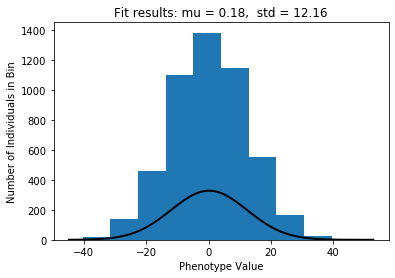

In [615]:
# genos_byinds = run_geno_simulation(samp_size=10000,seq_len=1000,L=50,num_individuals=5000)
# write_genovcf(genos_byinds,'test_genotype',1000)

causalpheno_pos_byrep,pgenos_byinds = run_pheno_simulation(samp_size=10000,seq_len=1000,L=50,num_individuals=5000)


In [621]:
# pgenos_byinds[0].keys()
for pos,genos in pgenos_byinds[0].items():
    print(pos,genos[0])
    if(pos == causalpheno_pos_byrep[0]):
        print('causal!')

162 (0, 0)
252 (0, 0)
causal!
499 (0, 0)
677 (0, 0)
691 (1, 0)
856 (0, 0)
863 (0, 0)


In [622]:
write_genovcf(pgenos_byinds,causalpheno_pos_byrep,'test_fullgenos',1000)
# phenos_byinds[0]
# write_genovcf(phenos_byinds,'test_pheno_out.v1',1000)

In [620]:
def write_genovcf(full_geno_dict,causal_pos_dict,outname,seq_len,window_spacer=1000):
#     full_len = len(full_geno_dict)*(seq_len + (window_spacer*2))
    full_len = len(full_geno_dict)*window_spacer
    header_string = '##fileformat=VCFv4.2 \n##source=tskit 0.2.2 \n##FILTER=<ID=PASS,Description="All filters passed"> \n##INFO=<ID=CS,Number=0,Type=Flag,Description="SNP Causal to Phenotype"> \n##contig=<ID=1,length={0}>\n##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype"> \n'.format(full_len)
    vcf_file = open('/local3/jake/admix_simul/testing/{0}.vcf'.format(outname),'w')
    vcf_file.write(header_string)
    vcf_file.write('#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\tFORMAT\t')
    new_ids = []
    for i in range(len(full_geno_dict[0][causal_pos_dict[0]])):
        curr_nid = ''.join(['ID',str(i)])
        new_ids.append(curr_nid)
        vcf_file.write('{0}\t'.format(curr_nid))
    vcf_file.write('\n')
    for rep,geno_dict in full_geno_dict.items():
        is_rep_causalsnp = False
        for pos,genos in geno_dict.items():
            try:
                curr_pos = (int(rep)*window_spacer)+pos
                if(pos == causal_pos_dict[rep]):
                    is_rep_causalsnp = True
                    vcf_file.write('1\t{0}\t.\tA\tG\t.\tPASS\tCS\tGT\t'.format(curr_pos))
                else:
                    vcf_file.write('1\t{0}\t.\tA\tG\t.\tPASS\t.\tGT\t'.format(curr_pos))
                for g in genos:
                    vcf_file.write('{0}|{1}\t'.format(g[0],g[1]))
                vcf_file.write('\n')
            except:
                print(rep,genos)
    
        

In [571]:
def write_phenovcf(pheno_dict,outname,seq_len):
    header_string = '##fileformat=VCFv4.2 \n##source=tskit 0.2.2 \n##FILTER=<ID=PASS,Description="All filters passed"> \n##contig=<ID=1,length=1000>\n##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype"> \n'
    vcf_file = open('/local3/jake/admix_simul/testing/{0}.vcf'.format(outname),'w')
    vcf_file.write(header_string)
    vcf_file.write('#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\tFORMAT\t')
    new_ids = []
    for i in range(len(geno_dict[0][1])):
        curr_nid = ''.join(['ID',str(i)])
        new_ids.append(curr_nid)
        vcf_file.write('{0}\t'.format(curr_nid))
    vcf_file.write('\n')
    for rep,genos in geno_dict.items():
        curr_pos = (int(rep)*seq_len)+genos[0]
        vcf_file.write('1\t{0}\t.\tA\tG\t.\tPASS\t.\tGT\t'.format(curr_pos))
        for g in genos[1]:
            vcf_file.write('{0}|{1}\t'.format(g[0],g[1]))
        vcf_file.write('\n')

In [492]:
# def make_genovcf(samp_size,seq_len,L,num_individuals):
samp_size=40
num_individuals=20
tree_sequence = msprime.simulate(sample_size=samp_size, Ne=1e4, length=seq_len, recombination_rate=2e-8,mutation_rate=2e-8) 
new_ids = []
for i in range(num_individuals):
    new_ids.append(''.join(['ID',str(i)]))
    
with open("/local3/jake/admix_simul/test_treeoutput.vcf", "w") as vcf_file:
    tree_sequence.write_vcf(vcf_file, ploidy=2,individual_names=new_ids,)
    

    
    

In [513]:
new_ids = []
for i in range(len(phenotypes_byinds.items())):
    new_ids.append(''.join(['ID',str(i)]))
for ind,p in phenotypes_byinds.items():
    print(new_ids[ind],p)

ID0 54.0
ID1 62.5
ID2 58.0
ID3 49.5
ID4 57.0
ID5 53.0
ID6 52.5
ID7 53.5
ID8 60.5
ID9 54.5
ID10 49.0
ID11 46.0
ID12 53.5
ID13 52.0
ID14 51.0
ID15 56.0
ID16 52.0
ID17 55.5
ID18 55.5
ID19 54.5
ID20 53.0
ID21 56.5
ID22 53.0
ID23 51.5
ID24 54.0
ID25 53.0
ID26 50.0
ID27 54.5
ID28 49.0
ID29 48.0
ID30 54.0
ID31 54.0
ID32 59.5
ID33 60.0
ID34 53.5
ID35 56.0
ID36 59.0
ID37 47.0
ID38 47.5
ID39 54.5
ID40 53.5
ID41 49.5
ID42 51.5
ID43 56.0
ID44 52.0
ID45 56.5
ID46 57.5
ID47 50.0
ID48 62.0
ID49 53.0
ID50 49.5
ID51 56.5
ID52 55.0
ID53 47.0
ID54 56.5
ID55 53.5
ID56 53.5
ID57 53.0
ID58 50.0
ID59 57.5
ID60 50.5
ID61 51.0
ID62 54.0
ID63 49.5
ID64 55.0
ID65 57.0
ID66 49.5
ID67 51.5
ID68 48.5
ID69 48.5
ID70 59.5
ID71 55.5
ID72 53.0
ID73 51.0
ID74 50.0
ID75 54.0
ID76 50.5
ID77 54.0
ID78 51.5
ID79 54.5
ID80 52.5
ID81 55.5
ID82 54.5
ID83 54.0
ID84 51.5
ID85 52.0
ID86 49.0
ID87 49.5
ID88 53.5
ID89 52.5
ID90 53.0
ID91 58.0
ID92 50.0
ID93 48.0
ID94 53.0
ID95 51.5
ID96 57.0
ID97 46.5
ID98 51.0
ID99 47.5
ID100 55.0

ID965 53.0
ID966 53.5
ID967 57.5
ID968 55.0
ID969 51.5
ID970 52.0
ID971 53.5
ID972 52.0
ID973 58.5
ID974 55.5
ID975 54.0
ID976 52.5
ID977 53.5
ID978 55.0
ID979 55.0
ID980 52.5
ID981 50.0
ID982 54.0
ID983 52.5
ID984 51.0
ID985 55.0
ID986 48.0
ID987 51.0
ID988 55.0
ID989 50.5
ID990 50.5
ID991 52.5
ID992 54.0
ID993 55.0
ID994 55.0
ID995 53.0
ID996 52.5
ID997 57.0
ID998 58.5
ID999 58.0
ID1000 54.5
ID1001 54.0
ID1002 51.5
ID1003 50.0
ID1004 51.5
ID1005 51.0
ID1006 46.5
ID1007 60.5
ID1008 50.5
ID1009 48.5
ID1010 55.0
ID1011 56.0
ID1012 56.0
ID1013 58.0
ID1014 51.5
ID1015 53.5
ID1016 50.5
ID1017 59.5
ID1018 54.0
ID1019 50.5
ID1020 56.5
ID1021 64.5
ID1022 54.0
ID1023 51.5
ID1024 57.5
ID1025 56.0
ID1026 50.0
ID1027 56.5
ID1028 55.0
ID1029 47.0
ID1030 59.0
ID1031 50.0
ID1032 59.0
ID1033 53.0
ID1034 52.0
ID1035 57.0
ID1036 58.5
ID1037 51.0
ID1038 53.0
ID1039 51.0
ID1040 47.5
ID1041 52.0
ID1042 47.5
ID1043 56.5
ID1044 53.5
ID1045 52.0
ID1046 52.0
ID1047 55.5
ID1048 59.0
ID1049 58.5
ID1050 54.0
ID1

ID1794 53.5
ID1795 56.0
ID1796 60.0
ID1797 55.0
ID1798 50.0
ID1799 48.5
ID1800 55.5
ID1801 55.0
ID1802 55.0
ID1803 55.0
ID1804 54.5
ID1805 49.0
ID1806 56.5
ID1807 52.5
ID1808 56.5
ID1809 56.0
ID1810 54.5
ID1811 54.0
ID1812 48.5
ID1813 58.5
ID1814 51.0
ID1815 46.0
ID1816 53.5
ID1817 52.0
ID1818 57.5
ID1819 51.5
ID1820 55.5
ID1821 57.5
ID1822 58.0
ID1823 56.0
ID1824 60.0
ID1825 50.5
ID1826 55.5
ID1827 50.5
ID1828 55.0
ID1829 53.0
ID1830 56.0
ID1831 54.0
ID1832 46.5
ID1833 50.5
ID1834 48.5
ID1835 55.0
ID1836 55.5
ID1837 55.5
ID1838 48.5
ID1839 49.5
ID1840 53.0
ID1841 52.5
ID1842 51.5
ID1843 52.5
ID1844 55.5
ID1845 52.5
ID1846 58.0
ID1847 51.5
ID1848 54.0
ID1849 59.0
ID1850 57.5
ID1851 55.0
ID1852 56.5
ID1853 49.0
ID1854 52.5
ID1855 52.5
ID1856 47.5
ID1857 51.0
ID1858 50.0
ID1859 57.0
ID1860 56.5
ID1861 49.0
ID1862 59.0
ID1863 50.0
ID1864 57.5
ID1865 51.0
ID1866 48.0
ID1867 54.5
ID1868 56.5
ID1869 52.0
ID1870 57.5
ID1871 64.0
ID1872 53.5
ID1873 49.5
ID1874 53.0
ID1875 44.0
ID1876 52.0
ID18

ID2670 56.5
ID2671 54.5
ID2672 54.0
ID2673 52.0
ID2674 48.5
ID2675 51.5
ID2676 50.5
ID2677 59.0
ID2678 54.0
ID2679 51.0
ID2680 50.5
ID2681 56.0
ID2682 50.0
ID2683 57.5
ID2684 51.5
ID2685 53.0
ID2686 51.0
ID2687 55.0
ID2688 54.0
ID2689 51.5
ID2690 51.0
ID2691 49.0
ID2692 54.5
ID2693 51.5
ID2694 59.0
ID2695 54.5
ID2696 55.0
ID2697 56.0
ID2698 54.5
ID2699 50.5
ID2700 62.5
ID2701 54.5
ID2702 55.0
ID2703 57.5
ID2704 47.5
ID2705 59.5
ID2706 56.0
ID2707 52.0
ID2708 55.0
ID2709 59.5
ID2710 56.0
ID2711 56.5
ID2712 54.5
ID2713 51.5
ID2714 52.0
ID2715 45.5
ID2716 53.5
ID2717 50.0
ID2718 52.0
ID2719 56.5
ID2720 53.5
ID2721 50.0
ID2722 50.0
ID2723 49.0
ID2724 55.5
ID2725 46.0
ID2726 51.5
ID2727 52.5
ID2728 50.5
ID2729 52.5
ID2730 53.5
ID2731 58.5
ID2732 55.0
ID2733 47.5
ID2734 52.0
ID2735 55.5
ID2736 56.0
ID2737 54.5
ID2738 50.0
ID2739 50.5
ID2740 50.0
ID2741 50.0
ID2742 52.5
ID2743 52.0
ID2744 51.0
ID2745 53.5
ID2746 52.5
ID2747 51.0
ID2748 55.5
ID2749 46.5
ID2750 52.0
ID2751 54.5
ID2752 54.5
ID27

ID3601 58.0
ID3602 53.5
ID3603 57.5
ID3604 52.0
ID3605 54.5
ID3606 51.0
ID3607 57.0
ID3608 55.0
ID3609 54.5
ID3610 58.0
ID3611 56.0
ID3612 47.0
ID3613 51.0
ID3614 57.0
ID3615 41.0
ID3616 52.5
ID3617 54.0
ID3618 52.5
ID3619 53.0
ID3620 58.0
ID3621 46.0
ID3622 55.5
ID3623 52.5
ID3624 58.0
ID3625 49.5
ID3626 50.0
ID3627 53.0
ID3628 57.0
ID3629 54.0
ID3630 53.0
ID3631 51.0
ID3632 47.5
ID3633 53.5
ID3634 50.0
ID3635 48.5
ID3636 53.5
ID3637 53.0
ID3638 52.5
ID3639 52.0
ID3640 55.0
ID3641 49.5
ID3642 48.5
ID3643 52.0
ID3644 53.0
ID3645 55.0
ID3646 51.5
ID3647 55.0
ID3648 48.5
ID3649 50.0
ID3650 59.5
ID3651 55.0
ID3652 52.0
ID3653 54.5
ID3654 55.0
ID3655 53.0
ID3656 54.0
ID3657 54.0
ID3658 51.5
ID3659 51.5
ID3660 54.0
ID3661 51.5
ID3662 52.5
ID3663 57.5
ID3664 52.5
ID3665 52.0
ID3666 45.5
ID3667 50.5
ID3668 53.0
ID3669 56.0
ID3670 52.0
ID3671 49.0
ID3672 53.0
ID3673 55.5
ID3674 53.5
ID3675 45.5
ID3676 54.5
ID3677 49.5
ID3678 52.5
ID3679 51.0
ID3680 54.5
ID3681 52.5
ID3682 61.0
ID3683 52.5
ID36

ID4601 55.0
ID4602 53.5
ID4603 55.5
ID4604 61.5
ID4605 58.5
ID4606 47.5
ID4607 49.5
ID4608 60.0
ID4609 50.5
ID4610 53.5
ID4611 51.0
ID4612 47.5
ID4613 48.0
ID4614 54.5
ID4615 55.5
ID4616 58.0
ID4617 50.5
ID4618 52.5
ID4619 58.0
ID4620 48.0
ID4621 58.0
ID4622 57.0
ID4623 51.5
ID4624 57.5
ID4625 61.5
ID4626 53.0
ID4627 52.0
ID4628 51.5
ID4629 46.0
ID4630 55.0
ID4631 49.0
ID4632 53.5
ID4633 54.5
ID4634 50.0
ID4635 54.0
ID4636 47.5
ID4637 51.0
ID4638 50.0
ID4639 39.0
ID4640 56.0
ID4641 48.0
ID4642 52.0
ID4643 47.0
ID4644 52.0
ID4645 56.0
ID4646 50.5
ID4647 56.5
ID4648 48.5
ID4649 50.0
ID4650 51.5
ID4651 50.0
ID4652 54.5
ID4653 59.0
ID4654 48.5
ID4655 52.0
ID4656 47.5
ID4657 51.5
ID4658 56.5
ID4659 47.5
ID4660 54.5
ID4661 53.5
ID4662 55.0
ID4663 49.5
ID4664 50.5
ID4665 59.0
ID4666 54.0
ID4667 51.5
ID4668 54.5
ID4669 54.0
ID4670 60.5
ID4671 56.0
ID4672 52.5
ID4673 51.0
ID4674 50.5
ID4675 62.5
ID4676 55.0
ID4677 56.0
ID4678 58.0
ID4679 54.0
ID4680 54.5
ID4681 62.5
ID4682 55.5
ID4683 52.0
ID46

In [511]:
num_individuals

20

In [203]:
samp_size = 20
seq_len = 5e3

tree_sequence = msprime.simulate(sample_size=samp_size, Ne=1e5, length=seq_len, recombination_rate=2e-8,mutation_rate=2e-8, 
                                )#random_seed=10)
# for variant in tree_sequence.variants():
#     print(variant.site.id, variant.site.position,round(variant.site.position),variant.alleles, variant.genotypes, sep="\t")

var_dict = {}#[list(v.genotypes) for v in tree_sequence.variants()]
for variant in tree_sequence.variants():
    var_dict[round(variant.site.position)] = list(variant.genotypes)

new_ids = []
for i in range(int(samp_size/2)):
    new_ids.append(''.join(['ID',str(i)]))

geno_dict = generate_haplotypes(var_dict,samp_size,int(seq_len))

pheno_list = estimate_phenos(geno_dict,seq_len,0.5,geno_dict.keys())

for p in pheno_list.items():
    print(p[0],p[1])

# geneticcomp_distr = np.random.normal(0.5,0.01,int(samp_size/2))

# for g in geno_dict.items():
#     print(g[0],estimate_pheno(g[1],seq_len,0.14,geneticcomp_distr[g[0]]))
    
# with open("/local3/jake/admix_simul/test_treeoutput.vcf", "w") as vcf_file:
#     tree_sequence.write_vcf(vcf_file, ploidy=2,individual_names=new_ids,)

TypeError: estimate_pheno() takes 3 positional arguments but 4 were given

In [207]:
var_dict[28]

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [198]:
for g in geno_dict.items():
    print(g[0],len(g[1][0]),g[1])



0 140 ['00000000010000000000001000010000110000000000000000110001000000000000100000010100010110001100000001100001001011010010100000010000000010011000', '01000000000000011000000000000101000010000001000001110001000000000000000000010000010110000100101000000000000011010010111001000000100000000000']
1 140 ['00000000010000000000001000010000110000000000000000110001000000000000100000010100010110001100000001100001001011010010100000010000000010011000', '00000001000000000100010000010000000011010010010000000110100000000000010001010001010110000100101000000000000011010100011001000000100000000000']
2 140 ['00000000010100000001001000010000110100000000000000110001000000000000100000010100010110001100000001110001001011010010100000010000010010011000', '10000001100000000100010000010000000010000001001000001000001100101000000100100000000001000001010100001010110000000010100100000010000011000110']
3 140 ['00000000010000000010001100010000110000100000000000110001000000000000100000010100010110001100000000000100000

In [154]:
for variant in test.variants():
    test = variant
    print(variant.site.id, variant.site.position,round(variant.site.position),variant.alleles, variant.genotypes, sep="\t")


0	1117.5072952820594	1118	('0', '1')	[0 1]
1	1216.610421234114	1217	('0', '1')	[0 1]


In [116]:
new_ids

['ID0', 'ID1', 'ID2', 'ID3', 'ID4', 'ID5', 'ID6', 'ID7', 'ID8', 'ID9']

In [155]:
def out_of_africa():
    # First we set out the maximum likelihood values of the various parameters
    # given in Table 1.
    N_A = 7300
    N_B = 2100
    N_AF = 12300
    N_EU0 = 1000
    N_AS0 = 510
    # Times are provided in years, so we convert into generations.
    generation_time = 25
    T_AF = 220e3 / generation_time
    T_B = 140e3 / generation_time
    T_EU_AS = 21.2e3 / generation_time
    # We need to work out the starting (diploid) population sizes based on
    # the growth rates provided for these two populations
    r_EU = 0.004
    r_AS = 0.0055
    N_EU = N_EU0 / math.exp(-r_EU * T_EU_AS)
    N_AS = N_AS0 / math.exp(-r_AS * T_EU_AS)
    # Migration rates during the various epochs.
    m_AF_B = 25e-5
    m_AF_EU = 3e-5
    m_AF_AS = 1.9e-5
    m_EU_AS = 9.6e-5
    # Population IDs correspond to their indexes in the population
    # configuration array. Therefore, we have 0=YRI, 1=CEU and 2=CHB
    # initially.
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=0, initial_size=N_AF),
        msprime.PopulationConfiguration(
            sample_size=1, initial_size=N_EU, growth_rate=r_EU),
        msprime.PopulationConfiguration(
            sample_size=1, initial_size=N_AS, growth_rate=r_AS)
    ]
    migration_matrix = [
        [      0, m_AF_EU, m_AF_AS],
        [m_AF_EU,       0, m_EU_AS],
        [m_AF_AS, m_EU_AS,       0],
    ]
    demographic_events = [
        # CEU and CHB merge into B with rate changes at T_EU_AS
        msprime.MassMigration(
            time=T_EU_AS, source=2, destination=1, proportion=1.0),
        msprime.MigrationRateChange(time=T_EU_AS, rate=0),
        msprime.MigrationRateChange(
            time=T_EU_AS, rate=m_AF_B, matrix_index=(0, 1)),
        msprime.MigrationRateChange(
            time=T_EU_AS, rate=m_AF_B, matrix_index=(1, 0)),
        msprime.PopulationParametersChange(
            time=T_EU_AS, initial_size=N_B, growth_rate=0, population_id=1),
        # Population B merges into YRI at T_B
        msprime.MassMigration(
            time=T_B, source=1, destination=0, proportion=1.0),
        # Size changes to N_A at T_AF
        msprime.PopulationParametersChange(
            time=T_AF, initial_size=N_A, population_id=0)
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,
        migration_matrix=migration_matrix,
        demographic_events=demographic_events)
#     dd.print_history()
#     tree_sequence = msprime.simulate(sample_size=samp_size, Ne=1e5, length=seq_len, recombination_rate=2e-8,mutation_rate=2e-8, 
#                                  random_seed=10)
#     tree_sequence = msprime.simulate(population_configurations=population_configurations,demographic_events=demographic_events,
#                                      Ne=N_AF, length=seq_len, recombination_rate=2e-8,mutation_rate=2e-8,migration_matrix=migration_matrix)
    return dd

In [156]:
test = out_of_africa()

In [158]:
msprime.simulate(test)

TypeError: 'DemographyDebugger' object cannot be interpreted as an integer